In [1]:
# Set project directory
import os
import sys


def project_dir():
    notebook_path = %pwd
    repo_name = "worldbank_data_exploration"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)


pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [2]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Dataset

In [3]:
from data_sources.load_dataset import load_time_series

time_series_dict, countries, years = load_time_series()

In [4]:
len(countries), countries[:10]

(79,
 array(['Albania', 'Angola', 'Australia', 'Azerbaijan', 'Bangladesh',
        'Belarus', 'Belgium', 'Bolivia', 'Brazil', 'Bulgaria'],
       dtype=object))

In [5]:
years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype=int64)

In [6]:
len(time_series_dict), time_series_dict.keys()

(43,
 dict_keys(['Access to electricity (% of population)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)', 'Age dependency ratio (% of working-age population)', 'Agricultural land (% of land area)', 'Agriculture, forestry, and fishing, value added (% of GDP)', 'Arable land (% of land area)', 'Arable land (hectares per person)', 'Birth rate, crude (per 1,000 people)', 'Cereal yield (kg per hectare)', 'Crop production index (2014-2016 = 100)', 'Death rate, crude (per 1,000 people)', 'Employment in agriculture, female (% of female employment) (modeled ILO estimate)', 'Employment in agriculture, male (% of male employment) (modeled ILO estimate)', 'Exports of goods and services (% of GDP)', 'Fertility rate, total (births per woman)', 'Fertilizer consumption (kilograms per hectare of arable land)', 'Food production index (2014-2016 = 100)', 'Forest area (% of land area)', 'GDP growth (annual %)', 'GDP per capita (current US$)', 'GNI per capita, Atlas method (current US$)',

In [7]:
time_series_dict["Access to electricity (% of population)"].shape, time_series_dict[
    "Total natural resources rents (% of GDP)"
].shape

((79, 19), (79, 19))

In [8]:
X_all = np.vstack(list(time_series_dict.values()))
X_all.shape

(3397, 19)

# Utils

In [9]:
from sklearn.metrics import mean_absolute_error

In [10]:
def plot_history(history, title, ymax=None, print_mae=True, key="loss", figsize=(8, 5)):
    plt.figure(figsize=figsize)

    plt.plot(np.arange(1, len(history[key]) + 1), history[key])

    plt.ylim(bottom=0)
    if ymax is not None:
        plt.ylim(top=ymax)

    plt.title(f"{title} ({min(history[key]):0.6f})")
    plt.grid()
    plt.show()


def plot_autoencoded(
    model,
    X,
    indices=[1, 100, 200, 300, 500, 650, 750, 900, 1000, 1127, 1394],
    rows=3,
    cols=4,
    figsize=(18, 11),
):
    plt.figure(figsize=figsize)

    X_enc = model.predict(X)

    normalizer = Normalizer()
    X_norm = normalizer.fit_transform(X)
    X_enc_norm = normalizer.transform(X_enc)

    mae_list = [
        mean_absolute_error(x, x_enc) * 10_000 for x, x_enc in zip(X_norm, X_enc_norm)
    ]
    indices = indices + [np.argmax(mae_list)]

    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        plt.plot(years, X[idx], label="true")
        plt.plot(years, X_enc[idx], label="autoencoded")
        plt.title(f"{idx:3}, mae: {mae_list[idx]:0.6f}", fontsize=10)

    plt.legend()
    plt.show()

In [11]:
def train_features(
    n_bottleneck,
    autoencoder_all,
    all_path,
    train=False,
    n_epochs=6000,
    lr=None,
    lr_patience=100,
    batch_size=512,
    verbose=0,
):
    for i, (feature, X) in enumerate(list(time_series_dict.items())):
        print(
            "==========================================================================================================================================="
        )
        print(f"({i + 1}) {feature}")
        print(
            "==========================================================================================================================================="
        )

        feature = feature[:65]  # trim feature
        model_path = f"{pwd}/feature_extraction/model_weights/autoencoder_{n_bottleneck}/{feature}"
        autoencoder = Autoencoder(
            n_bottleneck, input_len=INPUT_LEN, model_path=model_path
        )

        if train:
            autoencoder.load_weights(path=all_path, load_history=True)
            autoencoder.compile_and_train(
                X,
                n_epochs=n_epochs,
                lr=lr,
                verbose=verbose,
                lr_patience=lr_patience,
                batch_size=batch_size,
            )

        autoencoder.load_weights(load_history=True)

        print(
            f"Loss: {autoencoder.compile_and_evaluate(X):0.6f}. Before fine-tuning: {autoencoder_all.compile_and_evaluate(X):0.6f}"
        )


def eval_features(
    n_bottleneck, autoencoder_all, show_lr=False, indices=[1, 21, 37], ymax=40
):
    for feature, X in list(time_series_dict.items()):
        print(
            "==========================================================================================================================================="
        )
        print(feature)
        print(
            "==========================================================================================================================================="
        )

        feature = feature[:65]  # trim feature
        model_path = f"{pwd}/feature_extraction/model_weights/autoencoder_{n_bottleneck}/{feature}"
        autoencoder = Autoencoder(
            n_bottleneck, input_len=INPUT_LEN, model_path=model_path
        ).load_weights(load_history=True)

        print(
            f"Loss: {autoencoder.compile_and_evaluate(X):0.6f}. Before fine-tuning: {autoencoder_all.compile_and_evaluate(X):0.6f}"
        )

        plot_history(autoencoder.history, feature, ymax=ymax)
        if show_lr:
            plot_history(
                autoencoder.history,
                "Learning rate",
                key="lr",
                print_mae=False,
                figsize=(6, 4),
            )
        plot_autoencoded(
            autoencoder, X, indices=indices, rows=1, cols=4, figsize=(18, 4)
        )

# Train (n_bottleneck=2)

## Train on all time series types

In [12]:
from feature_extraction.utils import Normalizer
from feature_extraction import Autoencoder

N_BOTTLENECK = 2
INPUT_LEN = 19
ALL_PATH = f"{pwd}/feature_extraction/model_weights/autoencoder_{N_BOTTLENECK}/all"

In [13]:
autoencoder_all = Autoencoder(N_BOTTLENECK, input_len=INPUT_LEN, model_path=ALL_PATH)

# autoencoder_all.compile_and_train(X_all, n_epochs=8_000, verbose=2, lr=0.002, lr_patience=150, batch_size=512)

autoencoder_all.load_weights(load_history=True)

print(f"Loss: {autoencoder_all.compile_and_evaluate(X_all):0.6f}")

107/107 [==============================] - 2s 4ms/step - loss: 70.6845
Loss: 70.684494


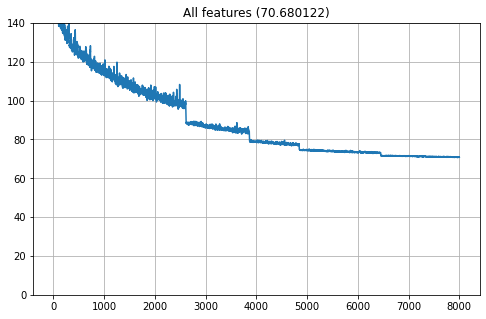

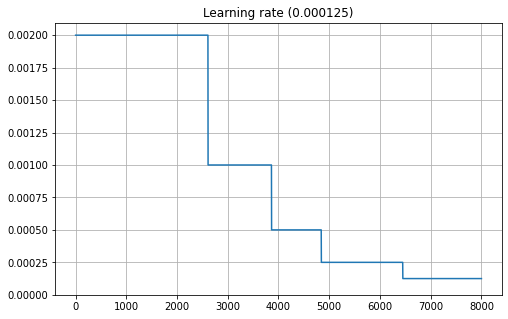

In [14]:
plot_history(autoencoder_all.history, "All features", ymax=140)
plot_history(autoencoder_all.history, "Learning rate", key="lr", print_mae=False)

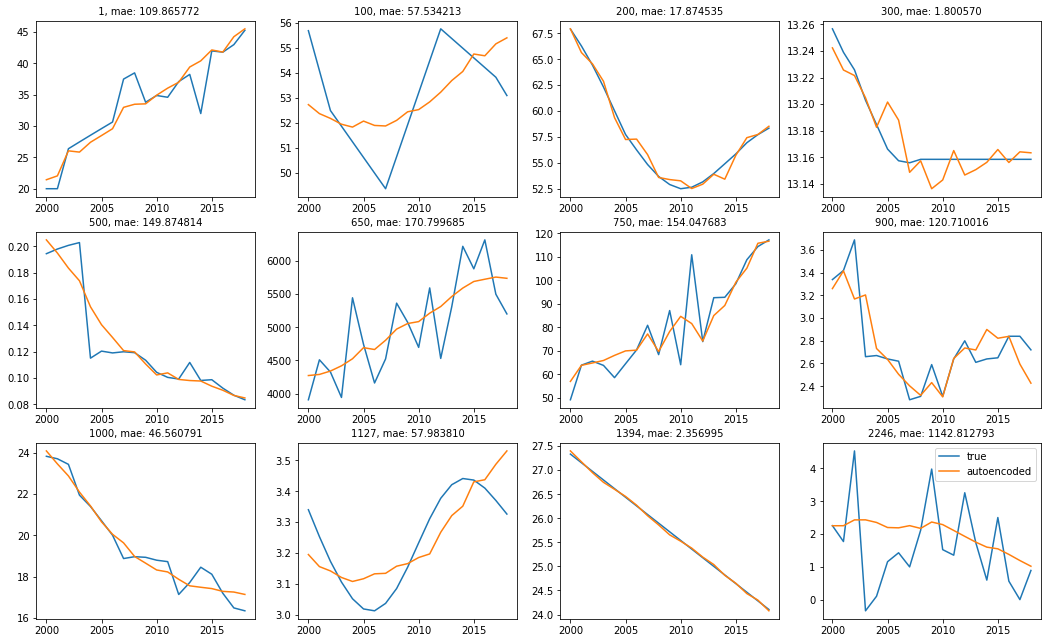

In [15]:
plot_autoencoded(autoencoder_all, X_all)

##  Fine-tune for each time series type

In [16]:
train_features(N_BOTTLENECK, autoencoder_all, ALL_PATH, train=False, lr=0.0002)

(1) Access to electricity (% of population)
3/3 [==============================] - 0s 4ms/step - loss: 15.7952
Loss: 5.043795. Before fine-tuning: 15.795160
(2) Adolescent fertility rate (births per 1,000 women ages 15-19)
3/3 [==============================] - 0s 8ms/step - loss: 34.4788
Loss: 6.370016. Before fine-tuning: 34.478760
(3) Age dependency ratio (% of working-age population)
3/3 [==============================] - 0s 4ms/step - loss: 14.1451
Loss: 4.079817. Before fine-tuning: 14.145099
(4) Agricultural land (% of land area)
3/3 [==============================] - 0s 5ms/step - loss: 24.3940
Loss: 6.816885. Before fine-tuning: 24.393959
(5) Agriculture, forestry, and fishing, value added (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 89.3126
Loss: 21.818350. Before fine-tuning: 89.312645
(6) Arable land (% of land area)
3/3 [==============================] - 0s 4ms/step - loss: 40.0316
Loss: 10.417878. Before fine-tuning: 40.031601
(7) Arable land (hec

In [17]:
# eval_features(N_BOTTLENECK, autoencoder_all, ymax=40, show_lr=False)

# Train (n_bottleneck=4)

## Train on all time series types

In [18]:
N_BOTTLENECK = 4
INPUT_LEN = 19
ALL_PATH = f"{pwd}/feature_extraction/model_weights/autoencoder_{N_BOTTLENECK}/all"

In [19]:
autoencoder_all = Autoencoder(N_BOTTLENECK, input_len=INPUT_LEN, model_path=ALL_PATH)

# autoencoder_all.compile_and_train(X_all, n_epochs=8_000, verbose=2, lr=0.002, lr_patience=150, batch_size=512)

autoencoder_all.load_weights(load_history=True)

print(f"Loss: {autoencoder_all.compile_and_evaluate(X_all):0.6f}")

107/107 [==============================] - 1s 3ms/step - loss: 27.1837
Loss: 27.183725


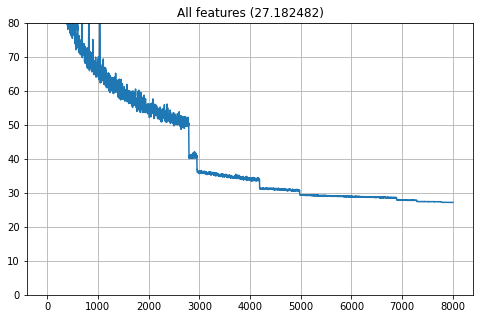

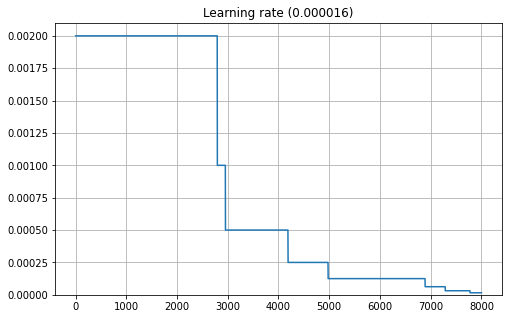

In [20]:
plot_history(autoencoder_all.history, "All features", ymax=80)
plot_history(autoencoder_all.history, "Learning rate", key="lr", print_mae=False)

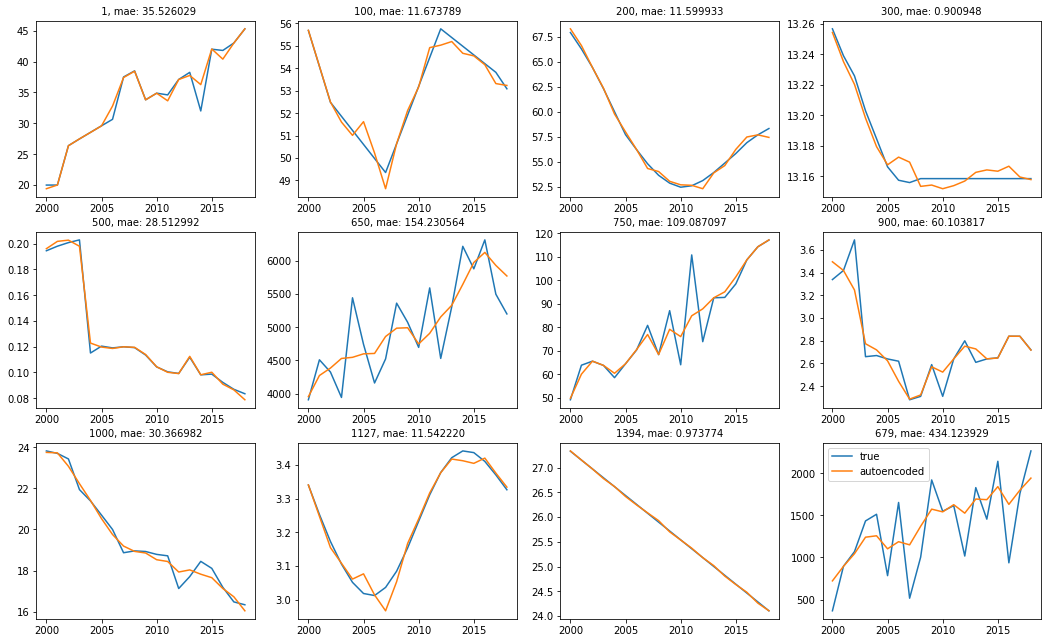

In [21]:
plot_autoencoded(autoencoder_all, X_all)

## Fine-tune for each time series type

In [22]:
train_features(N_BOTTLENECK, autoencoder_all, ALL_PATH, train=False, lr=0.0002)

(1) Access to electricity (% of population)
3/3 [==============================] - 0s 6ms/step - loss: 10.8504
Loss: 2.970361. Before fine-tuning: 10.850405
(2) Adolescent fertility rate (births per 1,000 women ages 15-19)
3/3 [==============================] - 0s 5ms/step - loss: 12.1730
Loss: 0.642894. Before fine-tuning: 12.173044
(3) Age dependency ratio (% of working-age population)
3/3 [==============================] - 0s 4ms/step - loss: 6.1188
Loss: 1.089291. Before fine-tuning: 6.118776
(4) Agricultural land (% of land area)
3/3 [==============================] - 0s 8ms/step - loss: 14.8350
Loss: 2.529994. Before fine-tuning: 14.834979
(5) Agriculture, forestry, and fishing, value added (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 50.3768
Loss: 1.856915. Before fine-tuning: 50.376755
(6) Arable land (% of land area)
3/3 [==============================] - 0s 5ms/step - loss: 21.2194
Loss: 2.329273. Before fine-tuning: 21.219404
(7) Arable land (hectare

In [23]:
# eval_features(N_BOTTLENECK, autoencoder_all, ymax=20, show_lr=False)

# Train (n_bottleneck=8)

## Train on all time series types

In [24]:
N_BOTTLENECK = 8
INPUT_LEN = 19
ALL_PATH = f"{pwd}/feature_extraction/model_weights/autoencoder_{N_BOTTLENECK}/all"

In [25]:
autoencoder_all = Autoencoder(N_BOTTLENECK, input_len=INPUT_LEN, model_path=ALL_PATH)

# autoencoder_all.compile_and_train(X_all, n_epochs=8_000, verbose=2, lr=0.002, lr_patience=150, batch_size=512)

autoencoder_all.load_weights(load_history=True)

print(f"Loss: {autoencoder_all.compile_and_evaluate(X_all):0.6f}")

107/107 [==============================] - 1s 3ms/step - loss: 11.2087
Loss: 11.208674


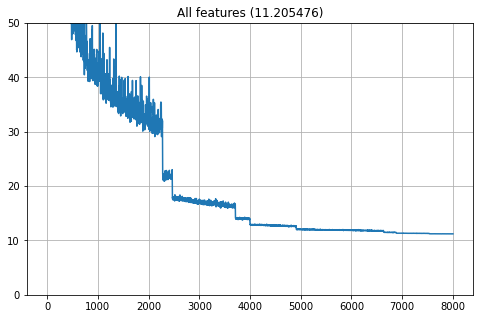

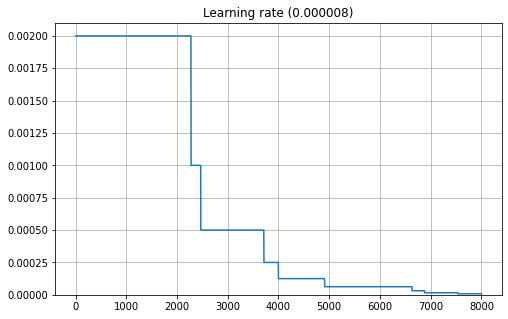

In [26]:
plot_history(autoencoder_all.history, "All features", ymax=50)
plot_history(autoencoder_all.history, "Learning rate", key="lr", print_mae=False)

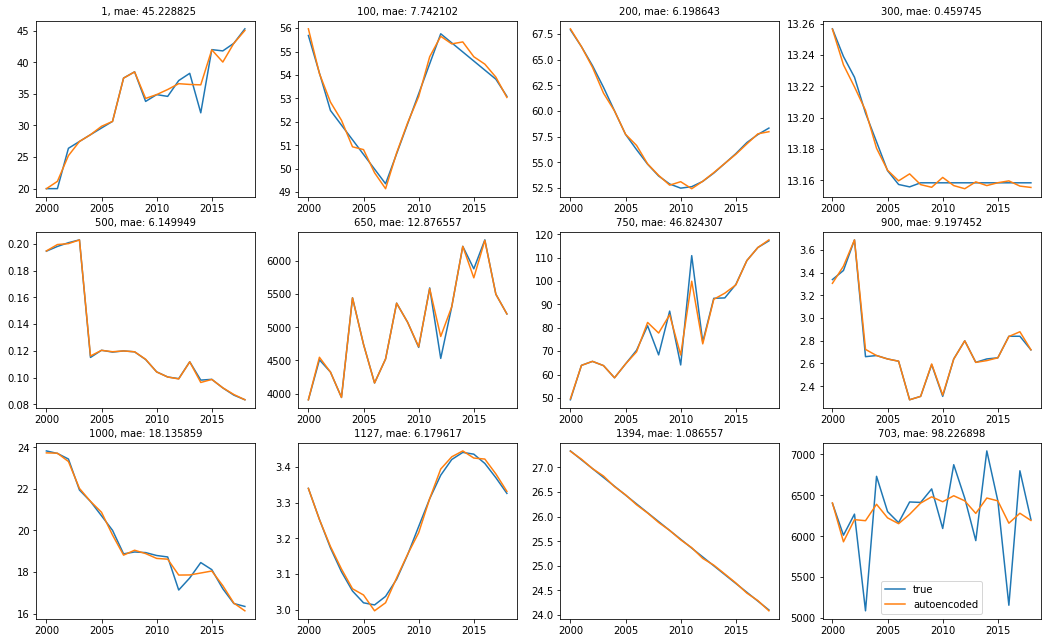

In [27]:
plot_autoencoded(autoencoder_all, X_all)

## Fine-tune for each time series type

In [28]:
train_features(N_BOTTLENECK, autoencoder_all, ALL_PATH, train=False, lr=0.0002)

(1) Access to electricity (% of population)
3/3 [==============================] - 0s 4ms/step - loss: 8.7429
Loss: 1.034649. Before fine-tuning: 8.742861
(2) Adolescent fertility rate (births per 1,000 women ages 15-19)
3/3 [==============================] - 0s 4ms/step - loss: 7.2906
Loss: 0.451865. Before fine-tuning: 7.290610
(3) Age dependency ratio (% of working-age population)
3/3 [==============================] - 0s 5ms/step - loss: 3.9674
Loss: 0.581767. Before fine-tuning: 3.967354
(4) Agricultural land (% of land area)
3/3 [==============================] - 0s 4ms/step - loss: 9.1830
Loss: 1.588773. Before fine-tuning: 9.183008
(5) Agriculture, forestry, and fishing, value added (% of GDP)
3/3 [==============================] - 0s 9ms/step - loss: 19.6267
Loss: 0.198926. Before fine-tuning: 19.626705
(6) Arable land (% of land area)
3/3 [==============================] - 0s 5ms/step - loss: 11.5513
Loss: 1.090775. Before fine-tuning: 11.551288
(7) Arable land (hectares per 

In [29]:
# eval_features(N_BOTTLENECK, autoencoder_all, ymax=10, show_lr=False)